## 2) Time series decomposition
## Overview
### 2.1) Components of a time serie
### 2.2) Trend
### 2.3) Seasonality
#### 2.3.1) Seasonal indicators
#### 2.3.2) Fourier features
### 2.4) Cycles
### 2.5) Residual
### 2.6) TS decomposition using statsmodels
### 2.7) TS decomposition using Prophet

### 2.1) Components of a time serie

* A time-serie (TS) is a set of observation recorded over time (usually, with constant frequency).

* In a TS, we can have the time as a feature and it affects the observating target. e.g. the season, week-day, and the hour of the day affects the sale of a shop. In addition, the past is affecting the future, which we call it a lag-feature. 

* A Time-serie can be decomposed into trend, seasonality, cycles, and residual. In addition, events and holidays (except the weekends which we consider it in weekly seasonality) also affects the TS target value.

* Trend is the lowest slowly-varying component of a TS. One can think of a slowly varying linear increase of stock-price of a company as the trent. It only varies significantly over long periods such as a year or few months.

* Seasonality is reqular oscillations with fixed frequencies in the TS. They can have different periods, e.g. two reqular frequencies in TSs are weekly seasonality and yearly seasonality (the effect of different months of the year).

* Cycles are irregular oscilations in the TS with varying factors. They usually, comes from a lag effect and the fact that the past affects the now and the future.

* Residual are what left from a TS and cannot be decomposed to above components. They usually should be fitted or described by external factors.

### 2.2) Trend
* The trend component of a time series represents a persistent, long-term change in the mean of the series. The trend is the slowest-moving part of a series.

* To find the trend we can use the time as a feature, then use linear or polynomial regression and fit a line or curve on it. 

* This can be done in several ways, one way is the statsmodels package:

In [19]:
import pandas as pd
tunnel = pd.read_csv("tunnel.csv", parse_dates=["Day"])
tunnel = tunnel.set_index("Day").to_period()
tunnel.head()

,NumVehicles
Day,
2003-11-01,103536
2003-11-02,92051
2003-11-03,100795
2003-11-04,102352
2003-11-05,106569


In [20]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=tunnel.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()

,const,trend
Day,,
2003-11-01,1.0,1.0
2003-11-02,1.0,2.0
2003-11-03,1.0,3.0
2003-11-04,1.0,4.0
2003-11-05,1.0,5.0


**Excercise**: 
- Play with order and constant and drop options and see what happens.
- Can you make a linear, or quadratic trend without using statsmodels? Of-course.! Do it please.

**Fit a curve for trend**
* Now we can fit a curve with linear(or polynomial) regression to our dataset

In [21]:
from sklearn.linear_model import LinearRegression

y = tunnel["NumVehicles"]  # the target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

* The good point about statsmodel is that we can easily extend the features to future and predict it with our ML model.

In [22]:
X = dp.out_of_sample(steps=30)

y_fore = pd.Series(model.predict(X), index=X.index)

y_fore.head()

2005-11-17    114981.801146
2005-11-18    115004.298595
2005-11-19    115026.796045
2005-11-20    115049.293494
2005-11-21    115071.790944
Freq: D, dtype: float64

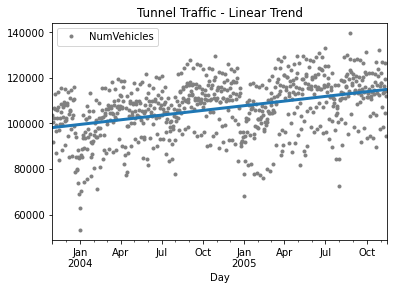

In [23]:
ax = tunnel.plot(style=".", color="0.5", title="Tunnel Traffic - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

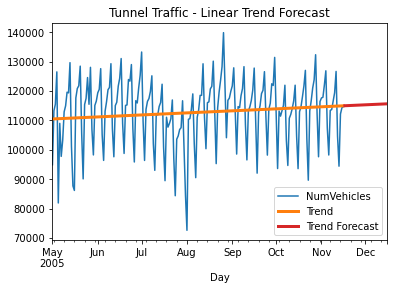

In [24]:
ax = tunnel["2005-05":].plot(title="Tunnel Traffic - Linear Trend Forecast")
ax = y_pred["2005-05":].plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()

* Are you happy with above trend? Then go to the next part. Do you think it is better to play with some options (such as fitting with a quadratic trend)? Be my guest, but at the end, do not forget the next part.

### 2.3) Seasonality

* Seasonality includes any repeating pattern with any constant frequency in a time-series. 

* Some examples are: - the effect of different months on the sale clothes. - Weekday effect on the price of oil. More? Think about it.

* We deal with long-period seasonality in different way than short-period ones. While for tha latter, we use seasonal indicator, for the former, it is more practical to use Fourier features. If the time-serie is for example daily-based, then a weekly seasonality would fits into short term and yearly seasonality fits into long term.

#### 2.3.1) Seasonal indicators

* In this method, we treat the components of seasonal variable (e.g. in weekly seasonality it will be the weekday) as a categorical feature, and then apply the one-hot-encoding and finally fit the time serie with linear regression (or another ML method).

* Linear regression works best if you drop one of the indicators, e.g. Monday, then it considers it as an intercept.

**Excercise** 
* Use the previous TS (tunnel) and explore the weekday effect in it.
* First, subtract a linear trend from it. Then, make categorical feature for weekdays, do the one-hot encoding and remove one of them. Finally apply the linear regression.
* Now, use the mean of the effect of different days: subtract the trend, make another feature named day of the week or something, groupby and average over that feature.
* Compare the results

#### 2.3.2) Fourier features

* For long seasons, it is impractical to use indicators over many observations, instead we use Fourier transformation with fourier components. 

**Computing Furier** 

* We can define the Fourier components by using the following function:

In [25]:
import numpy as np


def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)


# Compute Fourier features to the 4th order (8 new features) for a
# series y with daily observations and annual seasonality:
#
# fourier_features(y, freq=365.25, order=4)

* However, statsmodels package do all these things (trend, indicators, and Fourier components) for us:

In [26]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq="A", order=10)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=tunnel.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()  # create features for dates in tunnel.index

In [27]:
X.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)",...,"sin(6,freq=A-DEC)","cos(6,freq=A-DEC)","sin(7,freq=A-DEC)","cos(7,freq=A-DEC)","sin(8,freq=A-DEC)","cos(8,freq=A-DEC)","sin(9,freq=A-DEC)","cos(9,freq=A-DEC)","sin(10,freq=A-DEC)","cos(10,freq=A-DEC)"
Day,,,,,,,,,,,,,,,,,,,,,
2003-11-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.867456,0.497513,...,-0.017213,0.999852,-0.875892,0.482508,-0.854322,-0.519744,0.025818,-0.999667,0.880012,-0.474951
2003-11-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.858764,0.512371,...,0.085965,0.996298,-0.811539,0.584298,-0.917584,-0.397543,-0.128748,-0.991677,0.785650,-0.618671
2003-11-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.849817,0.527078,...,0.188227,0.982126,-0.735417,0.677615,-0.963471,-0.267814,-0.280231,-0.959933,0.668064,-0.744104
2003-11-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.840618,0.541628,...,0.288482,0.957485,-0.648630,0.761104,-0.991114,-0.133015,-0.425000,-0.905193,0.530730,-0.847541
2003-11-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.831171,0.556017,...,0.385663,0.922640,-0.552435,0.833556,-0.999991,0.004304,-0.559589,-0.828770,0.377708,-0.925925


Now, It is time to fit it with a regression model

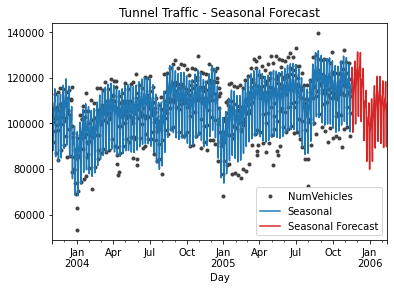

In [28]:
y = tunnel["NumVehicles"]

model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title="Tunnel Traffic - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

### 2.4) Cycles

**Serial Dependency** : 
* So far, we see the TS properties that deponds on the time index. However, there are properties that instead of depending on the current time, they depond on what happened in the past. These properties may not be apparent from a plot over time but they appear in plots against past values.

**Cycles** :
* One of special cases of serial dependencies is cycle. It is up and downs in the TS, that do not depend on the time, but on what happened in the past. Hence, in contrast to the seasonality they don't have a reqular pattern with some fixed frequencies.

**Lagged feature**:
* To investigate the cycles it is needed to add the information about the past to the dataset. It can be done by using the lag features. Lagging a time series means to shift its values forward one or more time steps.

* The lag effect csan be captured by the **shift** method.

In [15]:

import pandas as pd

# Federal Reserve dataset: https://www.kaggle.com/federalreserve/interest-rates
reserve = pd.read_csv(
    "reserve.csv",
    parse_dates={'Date': ['Year', 'Month', 'Day']},
    index_col='Date',
)

y = reserve.loc[:, 'Unemployment Rate'].dropna().to_period('M')
df = pd.DataFrame({
    'y': y,
    'y_lag_1': y.shift(1),
    'y_lag_2': y.shift(2),    
})

df.head()

,y,y_lag_1,y_lag_2
Date,,,
1954-07,5.8,NaN,NaN
1954-08,6.0,5.8,NaN
1954-09,6.1,6.0,5.8
1954-10,5.7,6.1,6.0
1954-11,5.3,5.7,6.1


* Now the unemployment rate of past month and past two months can be used as a feature to predict current unemployment rate.

**How many lags should we conside?**

* This can be answered by the partial autocorrelation plot:

/Users/fariborz/miniconda3/envs/jupyter_env/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


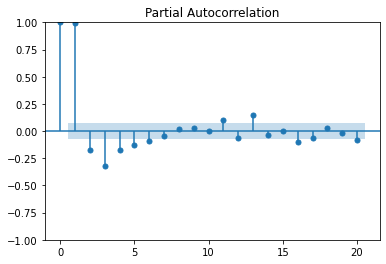

In [18]:
from statsmodels.graphics.tsaplots import plot_pacf

_ = plot_pacf(reserve.loc[:, 'Unemployment Rate'].dropna().to_period('M'), lags=20)

Using this, we can choose lags till 6 months before. lags of 11,13 are false positive.

### 2.5) Reseduals

* What is left is reseduals. It is mostly coming from external factors that are not in the time-series format. For example, external investments in the sale of the company. One way to work on it, is to exclude seasonalities, and trend from a TS and make it stationary (**Excercise**: Search and find out what is stationarity in a TS), then model the rest with other external factors. However, we should keep in mind that external factors affect the trend and seasonality.
For example, assume acompany with increasing trend. external investment such as advertisement has a direct effect on the trend and without them the trend might decrease after a certain period of time. I will discuss this in Lesson 4 (multi-variate TS prediction).

### 2.6) TS decompositio with Statsmodels

So far we learned what are different components of a TS and how to decompose them. In this part and the next part, we use two packages for decomposition.

In [32]:
import sys
import statsmodels as ss
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import seaborn as sns

from colorsetup import colors, palette
sns.set_palette(palette)


In [45]:
from statsmodels.tsa.seasonal import seasonal_decompose

ss_decomposition = seasonal_decompose(x=tunnel.NumVehicles.values, model='additive', period=120)
estimated_trend = ss_decomposition.trend
estimated_seasonal = ss_decomposition.seasonal
estimated_residual = ss_decomposition.resid

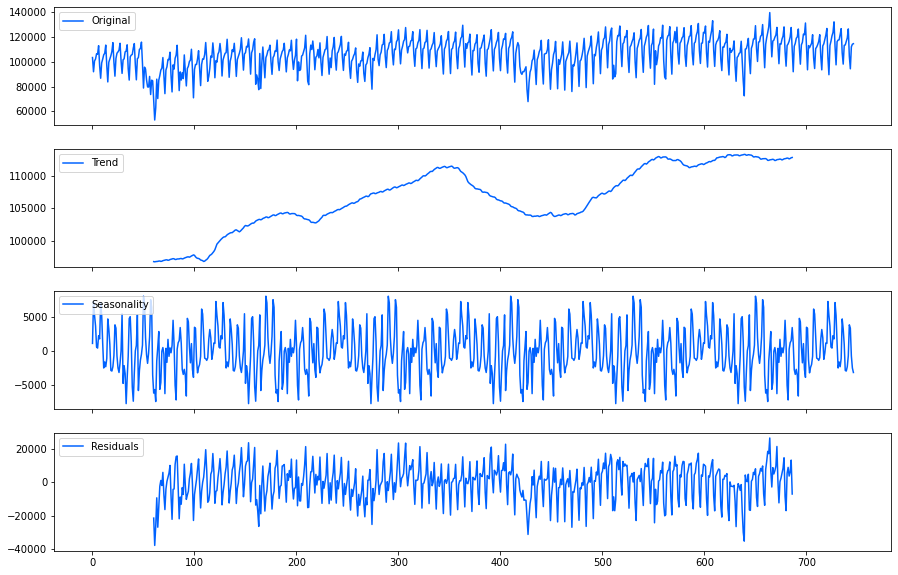

In [46]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(tunnel.NumVehicles.values, label='Original')
axes[0].legend(loc='upper left');

axes[1].plot(estimated_trend, label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(estimated_seasonal, label='Seasonality')
axes[2].legend(loc='upper left');

axes[3].plot(estimated_residual, label='Residuals')
axes[3].legend(loc='upper left');

**Excercise** Work on different options of above method.
* What is 'additive' model? What other choices exist? (multiplicative)
* What is period?
* How can we make the trend smoother?
* Add more questions/curiosity to above.

### 2.7) TS decomposition with Prophet

* Prophet is a package written by facebook group to do the TS decomposition. It is very useful and easy to use. However, it is a kind of black-box.

* This package needs the data to be in certain structure format. More precisely, the input dataframe should have the date columns with name 'ds' and target variable with the name 'y'. 

In [61]:
tunnel.index=tunnel.index.to_timestamp() # the index of tunnel data is of period type, but prophet accepts timestamp format
df_prophet = tunnel.reset_index()
df_prophet = df_prophet.rename(columns={'Day':'ds','NumVehicles':'y'})

* Then we can simply use the fit method to fit the data:

In [62]:
from prophet import Prophet 

model = Prophet()
model.fit(df_prophet)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.69543


/Users/fariborz/miniconda3/envs/jupyter_env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2032.01   0.000170915       86.8073      0.3588           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     187       2032.14    1.0304e-07       74.1729      0.3256           1      255   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


* A good point about prophet package is that it has been written in the format of sklearn package with fit and predict functions.

* As one of the goals of time-series approaches is to predict the future, prophet has a function to make a dataframe, including future.

In [63]:
future = model.make_future_dataframe(periods = 60)
pred= model.predict(future)

/Users/fariborz/miniconda3/envs/jupyter_env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/fariborz/miniconda3/envs/jupyter_env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


* Now lets look at the predicted dataframe

In [64]:
pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2003-11-01,99421.112305,94528.374457,108013.674788,99421.112305,99421.112305,1803.981666,1803.981666,1803.981666,-4426.748813,-4426.748813,-4426.748813,6230.730479,6230.730479,6230.730479,0.0,0.0,0.0,101225.093971
1,2003-11-02,99441.754642,81315.508638,95602.337685,99441.754642,99441.754642,-10965.065668,-10965.065668,-10965.065668,-17027.927805,-17027.927805,-17027.927805,6062.862137,6062.862137,6062.862137,0.0,0.0,0.0,88476.688974
2,2003-11-03,99462.396979,96637.169293,110523.134961,99462.396979,99462.396979,4254.211435,4254.211435,4254.211435,-1568.247877,-1568.247877,-1568.247877,5822.459313,5822.459313,5822.459313,0.0,0.0,0.0,103716.608415
3,2003-11-04,99483.039317,99032.975502,114113.367369,99483.039317,99483.039317,6586.357894,6586.357894,6586.357894,1071.481186,1071.481186,1071.481186,5514.876708,5514.876708,5514.876708,0.0,0.0,0.0,106069.397210
4,2003-11-05,99503.681654,102454.505422,116717.041181,99503.681654,99503.681654,9872.277518,9872.277518,9872.277518,4724.777452,4724.777452,4724.777452,5147.500067,5147.500067,5147.500067,0.0,0.0,0.0,109375.959172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
802,2006-01-11,109305.685565,96129.229477,110267.538168,109232.929327,109386.934398,-6228.506346,-6228.506346,-6228.506346,4724.777452,4724.777452,4724.777452,-10953.283798,-10953.283798,-10953.283798,0.0,0.0,0.0,103077.179219
803,2006-01-12,109297.365694,97681.189064,111726.629428,109224.649839,109379.906530,-4726.576007,-4726.576007,-4726.576007,5381.798996,5381.798996,5381.798996,-10108.375003,-10108.375003,-10108.375003,0.0,0.0,0.0,104570.789687
804,2006-01-13,109289.045823,104828.498841,118527.483094,109213.663645,109373.228595,2555.941793,2555.941793,2555.941793,11844.866862,11844.866862,11844.866862,-9288.925069,-9288.925069,-9288.925069,0.0,0.0,0.0,111844.987616
805,2006-01-14,109280.725952,88894.540480,103930.331717,109202.676042,109367.312234,-12937.552160,-12937.552160,-12937.552160,-4426.748813,-4426.748813,-4426.748813,-8510.803346,-8510.803346,-8510.803346,0.0,0.0,0.0,96343.173793


* First of all, this dataframe starts on the same date as the start of original dataset (df_prophet), but it lasts to 60 days more.

* The last column (yhat) is the predicted value for the time-series.

* Then, we have trend, weekly, yearly (two seasonality), additive_terms (residual), and for each of these terms we have lower and upper that shows the confidence interval.

* **Excercise**: What is multiplicative terms and why is it zero?
* **Excercise**: Can we have other seasonality other than weekly and yearly?
* **Excercise**: One of the very interesting useful and important features of prophet package is that it can take the effect of holidays and events into account. How can we include this feature?

#### Plotting

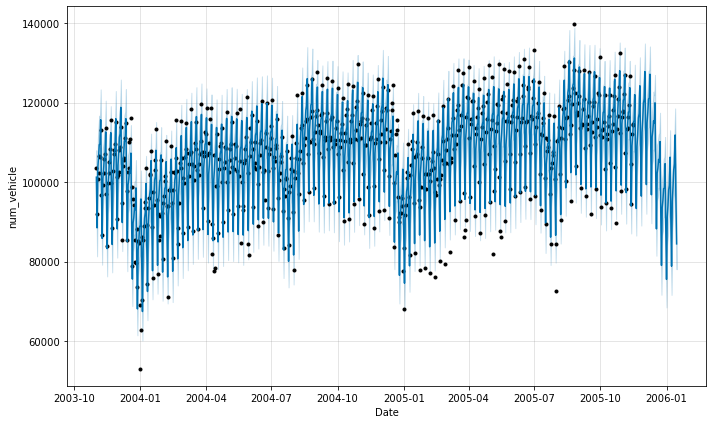

In [66]:
figure = model.plot(pred, xlabel='Date',ylabel='num_vehicle')

/Users/fariborz/miniconda3/envs/jupyter_env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/fariborz/miniconda3/envs/jupyter_env/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


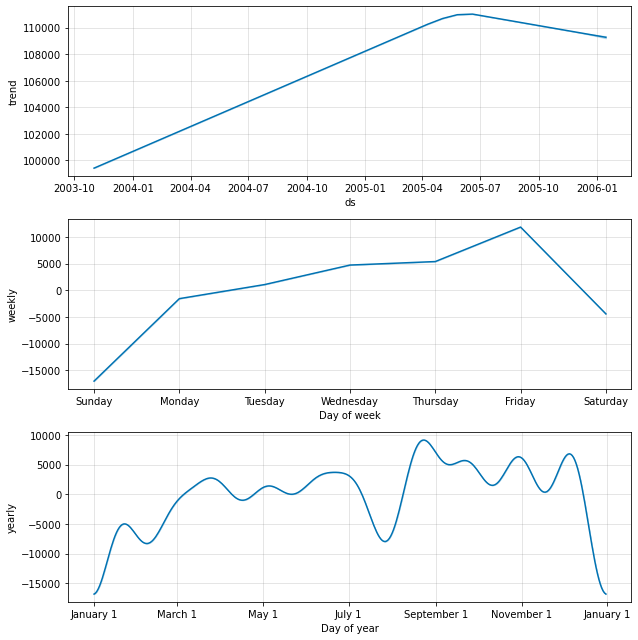

In [67]:
figure2 = model.plot_components(pred)